In [1]:
from pytket.pauli import Pauli, QubitPauliString
from pytket.utils import QubitPauliOperator
from pytket.circuit import Circuit,Qubit,CircBox
from pytket.circuit.display import render_circuit_jupyter
import numpy as np

## Hamiltonian
- Arbitrary Hamiltonian

In [2]:
hamiltonian = QubitPauliOperator(
    {
        QubitPauliString([Qubit(0)], [Pauli.Z]): 0.1,
        QubitPauliString(
            [Qubit(0), Qubit(1), Qubit(2), Qubit(3)],
            [Pauli.Y, Pauli.Z, Pauli.X, Pauli.X],
        ): 0.4,
        QubitPauliString([Qubit(0), Qubit(1)], [Pauli.X, Pauli.X]): 0.2,
    }
)

## Time Sliced Hamiltonian

In [3]:
t_max = 10
n_trotter_steps = 20
time_step = t_max / n_trotter_steps
time_space = np.linspace(0, t_max, n_trotter_steps)
print(f'Time step: {time_step}')

hamiltonian_slice = hamiltonian * time_step

Time step: 0.5


Pauli

## PauliExpBox
- Generate PauliExpBoxes for each term in Hamiltonian
- `gen_term_sequence_circuit` will generate a circuit with $ U = e^{iP_0\tau} e^{iP_1\tau} \cdots$
- Where the citcuit is partitions into various commuting sets https://arxiv.org/pdf/2007.10515.pdf


In [4]:
from pytket.utils import gen_term_sequence_circuit
initial_state = Circuit(4)
trotter_step_circ = gen_term_sequence_circuit(hamiltonian_slice,initial_state)


- We can obtain the pauli gadgets by looking into the component Circboxes

In [5]:
pauliexpbox0 = trotter_step_circ.get_commands()[1].op
box_circ = pauliexpbox0.get_circuit()

- And decomposing the PauliExpBox we can see it is a Pauli Gadget 

In [6]:
pauli_exp_box = box_circ.get_commands()[0].op
render_circuit_jupyter(pauli_exp_box.get_circuit())

## Trotter Step Box
- We can wrap up the pauli gagets into a trotter step bix using CircBox

In [7]:
trotter_step_box = CircBox(trotter_step_circ)

## Hamiltonian Simulation
- Define Operator to be simulated

In [8]:
n_qubits = 4
op_list = [QubitPauliString([Qubit(i)], [Pauli.Z]) for i in range(n_qubits)]


## Initial State
- Simple Fock State

In [9]:
initial_state = Circuit(n_qubits).X(0).X(1)

## Measure
- Use `get_pauli_expectation_value` for pauli words
- Use `get_operator_expectation_value` for linear combinations of paulis
- Using a statevector backend with n_shots = None
- This will work with a shots backend too

In [19]:
from pytket.utils import get_pauli_expectation_value
from pytket.extensions.qiskit import AerStateBackend
results = {}

# Statevector Backend
backend = AerStateBackend()

circ = initial_state
for t in time_space:
    circ.add_gate(trotter_step_box, circ.qubits)
    results[t] = [get_pauli_expectation_value(circ.copy(), pauli, backend, n_shots=None) for pauli in op_list]
    


<AxesSubplot: >

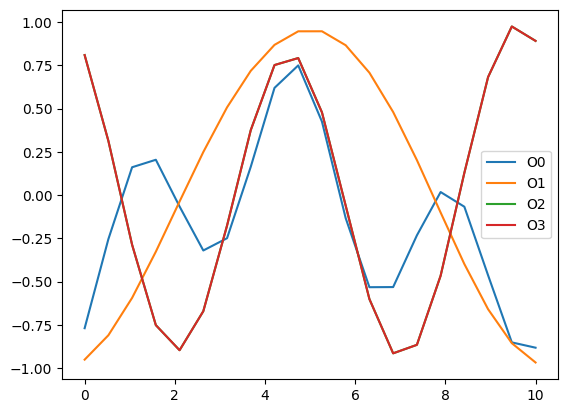

In [17]:
import pandas as pd
results_df = pd.DataFrame.from_dict(results,orient='index', columns=[f'O{i}' for i in range(n_qubits)])
results_df.plot()

In [18]:
results_df

,O0,O1,O2,O3
0.000000,-0.769421,-0.951057,0.809017,0.809017
0.526316,-0.254617,-0.810193,0.313271,0.313271
1.052632,0.160786,-0.594135,-0.287254,-0.287254
1.578947,0.204040,-0.327214,-0.751662,-0.751662
2.105263,-0.066020,-0.037193,-0.896653,-0.896653
2.631579,-0.320254,0.248740,-0.671187,-0.671187
3.157895,-0.249345,0.506827,-0.176700,-0.176700
3.684211,0.163596,0.718035,0.375394,0.375394
4.210526,0.619421,0.868007,0.751357,0.751357
4.736842,0.749400,0.946416,0.791832,0.791832
